# 1.Multigpu Distributed Training-ScriptMode
---

본 모듈에서는 Amzaon SageMaker API을 효과적으로 이용하기 위해 multigpu-distributed 학습을 위한 PyTorch 프레임워크 자체 구현만으로 모델 훈련을 수행해 봅니다.

## 1. Sagemaker notebook 설명
<p>Sagemaker notebook은 완전 관리형 서비스로 컨테이너 기반으로 구성되어 있습니다. 사용자가 직접 컨테이너를 볼 수 없지만, 내부적으로는 아래와 같은 원리로 동작합니다. </p>
<p><img src="./imgs/fig00.png" width="800", height="80"></p>

- **S3 (Simple Storage Serivce)** : Object Storage로서 학습할 데이터 파일과 학습 결과인 model, checkpoint, tensorboard를 위한 event 파일, 로그 정보 등을 저장하는데 사용합니다.
- **SageMaker Notebook** : 학습을 위한 스크립트 작성과 디버깅, 그리고 실제 학습을 수행하기 위한 Python을 개발하기 위한 환경을 제공합니다.
- **Amazon Elastic Container Registry(ECR)** :  Docker 컨테이너 이미지를 손쉽게 저장, 관리 및 배포할 수 있게 해주는 완전관리형 Docker 컨테이너 레지스트리입니다. Sagemaker는 기본적인 컨테이너를 제공하기 때문에 별도 ECR에 컨테이너 이미지를 등록할 필요는 없습니다. 하지만, 별도의 학습 및 배포 환경이 필요한 경우 custom 컨테이너 이미지를 만들어서 ECR에 등록한 후 이 환경을 활용할 수 있습니다.

<p>학습과 추론을 하는 hosting 서비스는 각각 다른 컨테이너 환경에서 수행할 수 있으며, 쉽게 다량으로 컨테이너 환경을 확장할 수 있으므로 다량의 학습과 hosting이 동시에 가능합니다.   
</p>

In [1]:
install_needed = True  # should only be True once
install_needed = False

In [2]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U split-folders tqdm albumentations crc32c sagemaker wget
    # !{sys.executable} -m pip install 'sagemaker[local]' --upgrade
    !{sys.executable} -m pip install -U bokeh smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

## 2. 환경 설정

<p>Sagemaker 학습에 필요한 기본적인 package를 import 합니다. </p>
<p>boto3는 HTTP API 호출을 숨기는 편한 추상화 모델을 가지고 있고, Amazon EC2 인스턴스 및 S3 버켓과 같은 AWS 리소스와 동작하는 파이선 클래스를 제공합니다. </p>
<p>sagemaker python sdk는 Amazon SageMaker에서 기계 학습 모델을 교육 및 배포하기 위한 오픈 소스 라이브러리입니다.</p>

In [3]:
import joblib
import matplotlib.pyplot as plt
import sagemaker
import splitfolders

import datetime
import glob
import os
import time
import warnings

import wget
import tarfile
import shutil

import boto3
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (Rule,
                                rule_configs,
                                ProfilerConfig, 
                                FrameworkProfile, 
                                DetailedProfilingConfig, 
                                DataloaderProfilingConfig, 
                                PythonProfilingConfig)

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [4]:
sagemaker.__version__

'2.24.4'

In [5]:
sess = boto3.Session()
sagemaker_session = sagemaker.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

## 3. S3의 저장 데이터 위치 가져오기
<p> 데이터를 정하기 위한 S3의 bucket 위치는 아래 data_bucket 이름으로 생성하며, 기본적으로 SageMaker에서 학습한 모델과 로그 정보를 남기는 위치는 자동으로 생성되는 bucket 이름으로 저장됩니다. </p>

In [6]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
data_bucket = 'sagemaker-{}-{}'.format(sess.region_name, account_id)
try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=data_bucket)
    else:
        sess.client('s3').create_bucket(Bucket=data_bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

## 4. Dataset 소개 및 split 후 S3 upload하기
<p>이번 학습에 사용할 이미지 데이터는 <strong><a href="https://www.robots.ox.ac.uk/~vgg/data/pets/" target="_blank" class ='btn-default'>Oxford-IIIT Pet Dataset</a></strong> 입니다. Oxford-IIIT Pet Dataset은 <strong>37</strong>개 다른 종의 개와 고양이 이미지를 각각 200장 씩 제공하고 있으며, Ground Truth 또한 Classification, Object Detection, Segmentation와 관련된 모든 정보가 있으나, 이번 학습에서는 37개 class에 대해 일부 이미지로 Classification 문제를 해결하기 위해 학습을 진행할 예정입니다.</p>
<p><img src="./imgs/pet_annotations.jpg" width="700", height="70"></p>    
<p>이미지 파일을 학습하기 위해 SageMaker Notebook 환경으로 upload를 합니다. 폴더 구조는 아래와 같은 형태로 구성되어야 합니다. </p>
<pre>
<div style='line-height:80%'>
    image_path/class1/Aimage_1<br>
                      Aimage_2<br>
                       ...<br>
                      Aimage_N<br>
    image_path/class2/Bimage_1<br>
                      Bimage_2<br>
                       ...<br>
                      Bimage_M<br>
</div>
</pre>

<p>SageMaker 학습을 위해 train/val로 분리한 폴더를 S3내 이전에 지정한 data_bucket 내 prefix 하위 폴더로 upload합니다. </p>

In [7]:
def make_dir(img_path, delete=True):
    import shutil, os
    try:
        if not os.path.exists(img_path):
            os.makedirs(img_path)
        else:
            if delete:
                shutil.rmtree(img_path)
    except OSError:
        print("Error")

In [8]:
rawimg_path = 'raw_img'
output_path = 'data'
dataset_path = './dataset'

make_dir(rawimg_path)
make_dir(dataset_path)

In [9]:
if not (os.path.isfile("images.tar.gz") and tarfile.is_tarfile("images.tar.gz")):
    wget.download('https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
tar = tarfile.open("images.tar.gz")
tar.extractall(path=rawimg_path)
tar.close()

In [10]:
file_dir = os.path.join(rawimg_path, 'images')
output_dir = os.path.join(rawimg_path, output_path)

for file_path in glob.glob(file_dir + "/*"):
    filename = file_path.split("/")[2]
    dir_name = filename.split("_")
    dir_name.pop()
    dir_name = "_".join(dir_name)
    dir_path = os.path.join(output_dir, dir_name)
    make_dir(dir_path, False)
    target_path = os.path.join(dir_path, filename)
    shutil.copyfile(file_path, target_path)

In [11]:
splitfolders.ratio(output_dir, output=dataset_path, seed=1337, ratio=(.8, .1, .1)) # default values
s3_data_path = 's3://{}/{}'.format(data_bucket, 'oxford_pet_dataset')
!aws s3 cp ./dataset $s3_data_path --quiet --recursive

Copying files: 7393 files [00:02, 3608.01 files/s]


## 5. Distributed Training

AWS에서 Multigpu distributed training은 `data_parallel`와 `model_parallel` 를 모두 사용할 수 있으며, 아래 예제는 data_parallel 중심으로 학습을 하게 됩니다. 

<!-- 
이번에는 Pytorch에서 활용할 수 있는 [APEX](https://github.com/NVIDIA/apex) (A Pytorch EXtension) 패키지를 이용하여 Multigpu distributed training을 수행합니다. APEX 패키지에는 distributed training 기능과 함께 mixed precision training도 할 수 있도록 지원하고 있습니다. 

<!-- 
<p><img src="./imgs/apex.png" width="1100", height="150"></p>  -->
<!-- - mixed precision training (apex.amp) : FP16과 FP32연산을 mixed하여 처리 속도와 정확도를 동시에 잡기 위해 학습을 하는 방법입니다. Tensor Cores에서 FP16를 이용하면 compute 처리량은 8배, 메모리 처리량은 2배 증가하는 반면 메모리 저장은 50% 절감됩니다. (FP : Floating Point, AMP: Automatic Mixed Precision) -->

- **[SageMaker Distributed Data Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html)** : AWS의 네트워크 인프라와 Balanced Fusion Buffers 를 이용하여 AWS SageMaker에 최적화된 data parallel 분산학습 알고리즘을 제공합니다.

- **[SageMaker Distributed Model Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/model-parallel.html)** : 각 GPU 또는 노드 간에 모델을 분할하고 GPU Utilization을 최대화하기 위해 모델을 학습하기 위한 효율적인 파이프 라인을 만든 후 mini-batch를 micro-batch를 분리하여 파이프 라인을 따라 Forward pass와 Backward pass를 동시에 수행할 수 있도록 제공하여 GPU의 Utilization을 최적화한 분산학습 알고리즘을 제공합니다. 


- **DataParallel (DP)** : 데이터 샘플의 미니 배치를 여러 개의 더 작은 미니 배치로 나누고 병렬로 작은 미니 배치를 각각 계산하는 방식이며, 단일 host에서 multi-gpu인 경우와 cpu 연산일 경우에 사용합니다. DP의 단점은 GPU가 즐어나면서 communication 비용이 높아지게 되면서 성능저하가 발생하게 되는데 일반적으로 4 gpu 이상일 경우 발생한다고 합니다. 또한, 타 GPU 메모리 대비 0번 GPU 메모리 사용량이 증가하는 현상도 발생합니다.  

- **Distributed Data Parallel (DDP)** : 모듈 수준에서 데이터 병렬 처리를 구현하는 것으로 torch.distributed 패키지의 communication collectives를 사용하여 gradient, parameters, buffers를 동기화합니다. 프로세스 내와 프로세스 간을 사용하는 multi-host의 multi-gpu 와 같은 경우에 사용하게 되는데, 프로세스 내에서는 DDP는 input 모듈을 device_id에 특정한 device로 복제하고, 그에 따라 배치 크기로 input을 분산시키며, outputs는 DataParallel과 유사하게 output_device로 모으게 됩니다.  

- **[APEX](https://nvidia.github.io/apex)** : apex.parallel.DistributedDataParallel는 모듈 wrapper이며, DDP와 유사합니다. 편리하게 Multi-process를 통한 distributed training을 지원하고, NCCL에 최적화하여 지원합니다.  

#### 1) 학습 스크립트 코딩하기

<p>SageMaker에서 학습하는 것이 아니더라도 실제 모델 아키텍처와 학습을 위한 optimizer와 loss 함수 등을 정의하는 python 파일을 구성하게 됩니다. SageMaker에서 활용하는 python 파일도 동일한 python 파일을 사용하게 됩니다. 연계되는 다른 소스코드 파일이 있는 경우에도 별도 소스코드 수정 없이 학습이 가능하며, SageMaker에서 사용하기 위해서는 기존 python 파일에 SageMaker 학습에 사용할 수 있는 환경변수들만 추가하면 됩니다. 예를 들어, 환경변수 중 <code>SM_MODEL_DIR</code>은 컨테이너 환경에서는 <code>/opt/ml/model</code>를 의미합니다. 다양한 환경변수는 <strong><a href="https://github.com/aws/sagemaker-containers" target="_blank" class ='btn-default'>SageMaker Containers-IMPORTANT ENVIRONMENT VARIABLES</a></strong>를 참고하시기 바랍니다. </p><p>SageMaker 학습이 끝나면 자동은 컨테이너 환경은 삭제가 됩니다. 따라서, 학습이 완료된 모델 산출물과 다양한 output 파일은 S3로 저장해야 합니다. SageMaker는 자동으로 <code>SM_MODEL_DIR</code>에 저장된 최종 모델 파일을 학습이 끝난 다음 model.tar.gz로 압축하여 컨테이너 환경에서 S3의 특정 bucket에 저장하게 됩니다.</p><p> 별도 bucket을 설정하지 않으며, 기본적으로 생성되는 bucket에 저장됩니다. 이외 학습에 이용되는 python source code는 SageMaker 학습이 시작되면서 S3에 저장되며, 별도로 <code>SM_MODEL_DIR</code>에 checkpoint 또는 log 파일을 저장하게 되면 학습이 끝난 이후 자동으로 컨테이너 환경에서 S3로 저장된 파일들이 이동하게 됩니다. 이런 과정을 이해한다면 학습 시 저장되는 다양한 정보들을 저장한 다음 학습이 끝난 후 S3에서 download 받아 활용할 수 있습니다. </p>

<p>아래는 시간 관계 상 미리 작성한 python 학습 스크립트 코드 입니다.</p>

In [12]:
%%writefile ./src_dir/requirements.txt
albumentations
pyarrow
torchnet
webdataset

Overwriting ./src_dir/requirements.txt


In [13]:
%%writefile ./src_dir/main_trainer.py

import argparse
import json
import logging
import os
import random
import sys
import time
import warnings
import cv2
from typing import Callable, cast

from albumentations import (
    RandomResizedCrop, HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE,
    RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion,
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise,
    MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Resize, VerticalFlip,
    HorizontalFlip, CenterCrop, Normalize)

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchnet.dataset import SplitDataset
import webdataset as wds

import dis_util
import util

# print("######### Start Training #########")

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


class AlbumentationImageDataset(Dataset):
    def __init__(self, image_path, transform, args, check_img=None):
        self.image_path = image_path
        self.transform = transform
        self.args = args
        self.check_img = check_img
        self.image_list = self._loader_file(self.image_path, self.check_img)

    def __len__(self):
        return (len(self.image_list))

    def __getitem__(self, i):

        image = cv2.imread(self.image_list[i][0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Augment an image
        transformed = self.transform(image=image)["image"]
        transformed_image = np.transpose(transformed,
                                         (2, 0, 1)).astype(np.float32)
        return torch.tensor(transformed_image,
                            dtype=torch.float), self.image_list[i][1]

    def _loader_file(self, image_path, check_img):
        extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif',
                      '.tiff', '.webp')

        def is_valid_file(x: str) -> bool:
            return x.lower().endswith(extensions)

        is_valid_file = cast(Callable[[str], bool], is_valid_file)

        self.classes = [d.name for d in os.scandir(image_path) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {
            cls_name: i
            for i, cls_name in enumerate(self.classes)
        }

        instances = []
        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(image_path, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir,
                                                  followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)

                    if is_valid_file(path):
                        not_insert = False
                        if check_img:
                            try:
                                image = cv2.imread(path)
                                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                                not_insert = False
                            except:
                                not_insert = True
                                pass
                        if not not_insert:
                            item = path, class_index
                            instances.append(item)
        return instances


def args_fn():
    parser = argparse.ArgumentParser(description='PyTorch Resnet50 Example')

    # Default Setting
    parser.add_argument(
        '--log-interval',
        type=int,
        default=5,
        metavar='N',
        help='how many batches to wait before logging training status')
    parser.add_argument(
        '--backend',
        type=str,
        default='nccl',
        help=
        'backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)'
    )
    parser.add_argument('--channels-last', type=bool, default=True)
    parser.add_argument('--seed',
                        type=int,
                        default=1,
                        metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('-p',
                        '--print-freq',
                        default=10,
                        type=int,
                        metavar='N',
                        help='print frequency (default: 10)')

    # Hyperparameter Setting
    parser.add_argument('--model_name', type=str, default='resnet50')
    parser.add_argument('--height', type=int, default=224)
    parser.add_argument('--width', type=int, default=224)
    parser.add_argument('--lr', type=float, default=0.0001)
    parser.add_argument('--num-classes', type=int, default=10)
    parser.add_argument('--num-epochs', type=int, default=3)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--test-batch-size',
                        type=int,
                        default=200,
                        metavar='N',
                        help='input batch size for testing (default: 200)')

    # Setting for Distributed Training
    parser.add_argument('--data_parallel', type=bool, default=False)
    parser.add_argument('--model_parallel', type=bool, default=False)
    parser.add_argument('--apex', type=bool, default=False)
    parser.add_argument('--opt-level', type=str, default='O0')
    parser.add_argument('--keep-batchnorm-fp32', type=str, default=None)
    parser.add_argument('--loss-scale', type=str, default=None)
    parser.add_argument('--sync_bn',
                        action='store_true',
                        help='enabling apex sync BN.')
    parser.add_argument('--prof',
                        default=-1,
                        type=int,
                        help='Only run 10 iterations for profiling.')

    # Setting for Model Parallel
    parser.add_argument("--horovod", type=int, default=0)
    parser.add_argument('--mp_parameters', type=str, default='')
    parser.add_argument("--ddp", type=int, default=0)
    parser.add_argument("--amp", type=int, default=0)
    parser.add_argument("--save_full_model", type=bool, default=True)
    parser.add_argument("--pipeline", type=str, default="interleaved")
    parser.add_argument("--assert-losses", type=int, default=0)
    parser.add_argument("--partial-checkpoint",
                        type=str,
                        default="",
                        help="The checkpoint path to load")
    parser.add_argument("--full-checkpoint",
                        type=str,
                        default="",
                        help="The checkpoint path to load")
    parser.add_argument("--save-full-model",
                        action="store_true",
                        default=False,
                        help="For Saving the current Model")
    parser.add_argument(
        "--save-partial-model",
        action="store_true",
        default=False,
        help="For Saving the current Model",
    )

    # SageMaker Container environment
    parser.add_argument('--hosts',
                        type=list,
                        default=json.loads(os.environ['SM_HOSTS']))
    parser.add_argument('--current-host',
                        type=str,
                        default=os.environ['SM_CURRENT_HOST'])
    parser.add_argument('--model-dir',
                        type=str,
                        default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--data-dir',
                        type=str,
                        default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--num-gpus',
                        type=int,
                        default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--output_data_dir',
                        type=str,
                        default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--rank', type=int, default=0)

    args = parser.parse_args()
    return args


def _get_train_data_loader(args, **kwargs):

    transform = Compose([
        RandomResizedCrop(args.height, args.width),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        VerticalFlip(p=0.5),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ],
              p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ],
              p=0.3),
        HueSaturationValue(p=0.3),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ],
                        p=1.0)

    train_sampler = None
    train_dataloader = None

    dataset = AlbumentationImageDataset(image_path=os.path.join(
        args.data_dir, 'train'),
                                        transform=transform,
                                        args=args,
                                        check_img=True)

    drop_last = args.model_parallel

    train_sampler = data.distributed.DistributedSampler(
        dataset, num_replicas=int(args.world_size), rank=int(
            args.rank)) if args.multigpus_distributed else None
    train_dataloader = data.DataLoader(dataset,
                                       batch_size=args.batch_size,
                                       shuffle=train_sampler is None,
                                       sampler=train_sampler,
                                       drop_last=drop_last,
                                       **kwargs)
    return train_dataloader, train_sampler


def _get_test_data_loader(args, **kwargs):
    logger.info("Get test data loader")
    transform = Compose([
        Resize(args.height, args.width),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])

    image_path = os.path.join(args.data_dir, 'val')
    dataset = AlbumentationImageDataset(image_path=image_path,
                                        transform=transform,
                                        args=args,
                                        check_img=True)

    drop_last = args.model_parallel
    print("test drop_last : {}".format(drop_last))
    test_sampler = data.distributed.DistributedSampler(
        dataset, num_replicas=int(args.world_size), rank=int(
            args.rank)) if args.multigpus_distributed else None

    return data.DataLoader(dataset,
                           batch_size=args.test_batch_size,
                           shuffle=False,
                           sampler=test_sampler,
                           drop_last=drop_last)


def train(local_rank, args):
    best_acc1 = -1
    model_history = {}
    model_history = util.init_modelhistory(model_history)
    train_start = time.time()

    if local_rank is not None:
        args.local_rank = local_rank

    # distributed_setting
    if args.multigpus_distributed:
        args = dis_util.dist_setting(args)

    # choose model from pytorch model_zoo
    model = util.torch_model(
        args.model_name,
        num_classes=args.num_classes,
        pretrained=True,
        local_rank=args.local_rank,
        model_parallel=args.model_parallel)  # 1000 resnext101_32x8d
    criterion = nn.CrossEntropyLoss().cuda()

    model, args = dis_util.dist_model(model, args)

    # CuDNN library will benchmark several algorithms and pick that which it found to be fastest
    cudnn.benchmark = False if args.seed else True

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    if args.apex:
        model, optimizer, args = dis_util.apex_init(model, optimizer, args)
    elif args.model_parallel:
        model, optimizer, args = dis_util.smp_init(model, optimizer, args)
    elif args.data_parallel:
        model, optimizer, args = dis_util.sdp_init(model, optimizer, args)

    train_loader, train_sampler = _get_train_data_loader(args, **args.kwargs)

    logger.info("Processes {}/{} ({:.0f}%) of train data".format(
        len(train_loader.sampler), len(train_loader.dataset),
        100. * len(train_loader.sampler) / len(train_loader.dataset)))

    test_loader = _get_test_data_loader(args, **args.kwargs)

    #     if args.rank == 0:
    logger.info("Processes {}/{} ({:.0f}%) of test data".format(
        len(test_loader.sampler), len(test_loader.dataset),
        100. * len(test_loader.sampler) / len(test_loader.dataset)))

    print(" local_rank : {}, local_batch_size : {}".format(
        local_rank, args.batch_size))

    for epoch in range(1, args.num_epochs + 1):
        ##
        batch_time = util.AverageMeter('Time', ':6.3f')
        data_time = util.AverageMeter('Data', ':6.3f')
        losses = util.AverageMeter('Loss', ':.4e')
        top1 = util.AverageMeter('Acc@1', ':6.2f')
        top5 = util.AverageMeter('Acc@5', ':6.2f')
        progress = util.ProgressMeter(
            len(train_loader), [batch_time, data_time, losses, top1, top5],
            prefix="Epoch: [{}]".format(epoch))

        model.train()
        end = time.time()

        # Set epoch count for DistributedSampler
        if args.multigpus_distributed and not args.model_parallel:
            train_sampler.set_epoch(epoch)

        for batch_idx, (input, target) in enumerate(train_loader):
            input = input.to(args.device)
            target = target.to(args.device)
            batch_idx += 1

            if args.model_parallel:
                output, loss = dis_util.train_step(model, criterion, input,
                                                   target, args.scaler, args)
                # Rubik: Average the loss across microbatches.
                loss = loss.reduce_mean()

            else:
                output = model(input)
                loss = criterion(output, target)

            if not args.model_parallel:
                # compute gradient and do SGD step
                optimizer.zero_grad()

            if args.apex:
                dis_util.apex_loss(loss, optimizer)
            elif not args.model_parallel:
                loss.backward()

            optimizer.step()

            if args.model_parallel:
                # compute gradient and do SGD step
                optimizer.zero_grad()

            if args.rank == 0:
                #             if args.rank == 0 and batch_idx % args.log_interval == 1:
                # Every print_freq iterations, check the loss, accuracy, and speed.
                # For best performance, it doesn't make sense to print these metrics every
                # iteration, since they incur an allreduce and some host<->device syncs.

                if args.model_parallel:
                    output = torch.cat(output.outputs)

                # Measure accuracy
                prec1, prec5 = util.accuracy(output, target, topk=(1, 5))

                # to_python_float incurs a host<->device sync
                losses.update(util.to_python_float(loss), input.size(0))
                top1.update(util.to_python_float(prec1), input.size(0))
                top5.update(util.to_python_float(prec5), input.size(0))

                # Waiting until finishing operations on GPU (Pytorch default: async)
                torch.cuda.synchronize()
                batch_time.update((time.time() - end) / args.log_interval)
                end = time.time()

                #                 if args.rank == 0:
                print(
                    'Epoch: [{0}][{1}/{2}] '
                    'Train_Time={batch_time.val:.3f}: avg-{batch_time.avg:.3f}, '
                    'Train_Speed={3:.3f} ({4:.3f}), '
                    'Train_Loss={loss.val:.10f}:({loss.avg:.4f}), '
                    'Train_Prec@1={top1.val:.3f}:({top1.avg:.3f}), '
                    'Train_Prec@5={top5.val:.3f}:({top5.avg:.3f})'.format(
                        epoch,
                        batch_idx,
                        len(train_loader),
                        args.world_size * args.batch_size / batch_time.val,
                        args.world_size * args.batch_size / batch_time.avg,
                        batch_time=batch_time,
                        loss=losses,
                        top1=top1,
                        top5=top5))

        acc1 = validate(test_loader, model, criterion, epoch, model_history,
                        args)

        is_best = False

        if args.rank == 0:
            is_best = acc1 > best_acc1
            best_acc1 = max(acc1, best_acc1)

        if not args.multigpus_distributed or (args.multigpus_distributed
                                              and not args.model_parallel
                                              and args.rank == 0):
            model_history['epoch'].append(epoch)
            model_history['batch_idx'].append(batch_idx)
            model_history['batch_time'].append(batch_time.val)
            model_history['losses'].append(losses.val)
            model_history['top1'].append(top1.val)
            model_history['top5'].append(top5.val)

            util.save_history(
                os.path.join(args.output_data_dir, 'model_history.p'),
                model_history)
            util.save_model(
                {
                    'epoch': epoch + 1,
                    'model_name': args.model_name,
                    'state_dict': model.state_dict(),
                    'best_acc1': best_acc1,
                    'optimizer': optimizer.state_dict(),
                    'class_to_idx': train_loader.dataset.class_to_idx,
                }, is_best, args)
        elif args.model_parallel:
            if args.rank == 0:
                util.save_history(
                    os.path.join(args.output_data_dir, 'model_history.p'),
                    model_history)
            dis_util.smp_savemodel(model, optimizer, is_best, args)


def validate(val_loader, model, criterion, epoch, model_history, args):
    batch_time = util.AverageMeter('Time', ':6.3f')
    losses = util.AverageMeter('Loss', ':.4e')
    top1 = util.AverageMeter('Acc@1', ':6.2f')
    top5 = util.AverageMeter('Acc@5', ':6.2f')
    progress = util.ProgressMeter(len(val_loader),
                                  [batch_time, losses, top1, top5],
                                  prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    end = time.time()

    #     print("**** validate *****")
    test_losses = []
    for batch_idx, (input, target) in enumerate((val_loader)):
        input = input.to(args.device)
        target = target.to(args.device)

        batch_idx += 1
        # compute output
        with torch.no_grad():
            if args.model_parallel:
                output, loss = dis_util.test_step(model, criterion, input,
                                                  target)
                loss = loss.reduce_mean()
                test_losses.append(loss)
            else:
                output = model(input)
                loss = criterion(output, target)

        # measure accuracy and record loss
        if args.model_parallel:
            output = torch.cat(output.outputs)

        prec1, prec5 = util.accuracy(output, target, topk=(1, 5))

        losses.update(util.to_python_float(loss), input.size(0))
        top1.update(util.to_python_float(prec1), input.size(0))
        top5.update(util.to_python_float(prec5), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        #         print("Validation args.rank : {}".format(args.rank))
        # TODO:  Change timings to mirror train().
        if args.rank == 0:
            print('Test: [{0}/{1}]  '
                  'Test_Time={batch_time.val:.3f}:({batch_time.avg:.3f}), '
                  'Test_Speed={2:.3f}:({3:.3f}), '
                  'Test_Loss={loss.val:.4f}:({loss.avg:.4f}), '
                  'Test_Prec@1={top1.val:.3f}:({top1.avg:.3f}), '
                  'Test_Prec@5={top5.val:.3f}:({top5.avg:.3f})'.format(
                      batch_idx,
                      len(val_loader),
                      args.world_size * args.batch_size / batch_time.val,
                      args.world_size * args.batch_size / batch_time.avg,
                      batch_time=batch_time,
                      loss=losses,
                      top1=top1,
                      top5=top5))
            model_history['val_epoch'].append(epoch)
            model_history['val_batch_idx'].append(batch_idx)
            model_history['val_batch_time'].append(batch_time.val)
            model_history['val_losses'].append(losses.val)
            model_history['val_top1'].append(top1.val)
            model_history['val_top5'].append(top5.val)

    model_history['val_avg_epoch'].append(epoch)
    model_history['val_avg_batch_time'].append(batch_time.avg)
    model_history['val_avg_losses'].append(losses.avg)
    model_history['val_avg_top1'].append(top1.avg)
    model_history['val_avg_top5'].append(top5.avg)

    if args.assert_losses:
        dist_util.smp_lossgather(losses.avg, args)
    return top1.avg


def main():
    print("start main function")
    args = args_fn()
    print(
        "args.data_parallel : {} , args.model_parallel : {}, args.apex : {} , args.num_gpus : {}, args.num_classes"
        .format(args.data_parallel, args.model_parallel, args.apex,
                args.num_gpus, args.num_classes))

    args.use_cuda = int(args.num_gpus) > 0

    args.kwargs = {
        'num_workers': 16,
        'pin_memory': True
    } if args.use_cuda else {}
    args.device = torch.device("cuda" if args.use_cuda else "cpu")
    args = dis_util.dist_init(train, args)


if __name__ == '__main__':
    main()


Overwriting ./src_dir/main_trainer.py


#### 2) 분산/멀티 gpu에 필요한 code 작성

apex사용과 분산을 위한 init 함수와 분산관련 다양한 함수를 제공합니다. 

In [14]:
%%writefile ./src_dir/dis_util.py

import argparse
import logging
import numpy as np
import os
import random
import sys
import shutil
import warnings
import importlib

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed
from torch.cuda.amp import autocast

import util

try:
    import smdistributed.modelparallel.torch as smp
    
except ImportError:
    pass
#     raise ImportError("Please install smdist.")


try:
    from apex.parallel import DistributedDataParallel as apexDDP
    import torch.distributed as apex
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError(
        "Please install apex from https://www.github.com/nvidia/apex to run this example."
    )

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def _sdp_import(args):
    # Remove the import of smdistributed.dataparallel as
    # that causes the MPI init/shutdown error at exit time

    try:
        sdp = importlib.import_module("smdistributed.dataparallel.torch.distributed")
        DDP = importlib.import_module("smdistributed.dataparallel.torch.parallel.distributed","DistributedDataParallel")
#         import smdistributed.dataparallel.torch.distributed as sdp
#         from smdistributed.dataparallel.torch.parallel.distributed import DistributedDataParallel as DDP
        return sdp, DDP

    except ImportError:
        pass
    #     raise ImportError("Please install smdist.")
    
    
    
def dist_init(fn, args):
    
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)
        torch.cuda.manual_seed_all(args.seed)
        cudnn.deterministic = True

        if cudnn.deterministic:
            warnings.warn('You have chosen to seed training. '
                          'This will turn on the CUDNN deterministic setting, '
                          'which can slow down your training considerably! '
                          'You may see unexpected behavior when restarting '
                          'from checkpoints.')

    args.is_distributed = len(args.hosts) > 1 and args.backend is not None
    args.is_multigpus = args.num_gpus > 1
    args.multigpus_distributed = (args.is_distributed or args.is_multigpus)

    logger.debug("multigpus_distributed - {}".format(
        args.multigpus_distributed))
    logger.debug("Number of gpus available - {}".format(args.num_gpus))

    if args.multigpus_distributed:
        if args.apex:
            # Initialize the distributed environment.
            mp.spawn(fn, nprocs=args.num_gpus, args=(args, ))
        else:
            if args.data_parallel:
                sdp, DDP = _sdp_import(args)
                sdp.init_process_group() if not sdp.is_initialized() else None    
            elif args.model_parallel:
                smp.init()
            fn(None, args)
            
    else:
        fn(0, args)


def dist_setting(args):
    #     args.data_parallel = False
    print("args.data_parallel : {}".format(args.data_parallel))
    print("args.model_parallel : {}".format(args.model_parallel))
    print("args.apex : {}".format(args.apex))

    args.world_size = 1
    args.host_num = args.hosts.index(args.current_host)

    if args.data_parallel:
        sdp, DDP = _sdp_import(args)
        
        args.world_size = sdp.get_world_size()
        args.rank = sdp.get_rank()  # total rank in all hosts
        args.local_rank = sdp.get_local_rank()  # rank per host
    elif args.model_parallel:
        args.world_size = smp.size()
        args.world_size = args.num_gpus * len(args.hosts)
        args.local_rank = smp.local_rank()  # rank per host
        args.rank = smp.rank()
        args.dp_size = smp.dp_size()
        args.dp_rank = smp.dp_rank()
    else:
        args.world_size = len(args.hosts) * args.num_gpus
        if args.local_rank is not None:
            args.rank = args.num_gpus * args.host_num + \
                args.local_rank  # total rank in all hosts

        dist.init_process_group(backend=args.backend,
                                rank=args.rank,
                                world_size=args.world_size)
        logger.info(
            'Initialized the distributed environment: \'{}\' backend on {} nodes. '
            .format(args.backend, dist.get_world_size()) +
            'Current host rank is {}. Number of gpus: {}'.format(
                dist.get_rank(), args.num_gpus))
    
#     if not args.model_parallel:
    args.lr = args.lr * float(args.world_size)
    args.batch_size //= args.world_size // args.num_gpus
    args.batch_size = max(args.batch_size, 1)

    return args


def dist_model(model, args):
    if args.multigpus_distributed:
        #     if args.sync_bn:
        # #         import apex
        #         print("using apex synced BN")
        #         model = apex.parallel.convert_syncbn_model(model)

        if args.local_rank is not None:
            torch.cuda.set_device(args.local_rank)

            if not (args.apex or args.data_parallel or args.model_parallel):
                model.cuda(args.local_rank)
                model = torch.nn.parallel.DistributedDataParallel(
                    model, device_ids=[args.rank])
        else:
            if not (args.apex or args.data_parallel or args.model_parallel):
                model.cuda()
                model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.rank is not None:
        torch.cuda.set_device(args.rank)
        if not (args.apex or args.data_parallel or args.model_parallel):
            model = model.cuda(args.rank)
    else:
        if not (args.apex or args.data_parallel or args.model_parallel):
            model = torch.nn.DataParallel(model).cuda()

    return model, args


def apex_init(model, optimizer, args):    
    model = model.cuda()
    model, optimizer = amp.initialize(
        model,
        optimizer,
        opt_level=args.opt_level,
        keep_batchnorm_fp32=args.keep_batchnorm_fp32,
        loss_scale=args.loss_scale)
    if args.multigpus_distributed:
        model = apexDDP(model, delay_allreduce=True)
    return model, optimizer, args


def sdp_init(model, optimizer, args):
    sdp, DDP = _sdp_import(args)
    
    model = DDP.DistributedDataParallel(model.to(args.device), broadcast_buffers=False)
    #     model = DDP(model, device_ids=[args.rank], broadcast_buffers=False)
    model.cuda(args.local_rank)
    return model, optimizer, args


def smp_init(model, optimizer, args):
    model = smp.DistributedModel(model)
    args.scaler = smp.amp.GradScaler()
    optimizer = smp.DistributedOptimizer(optimizer)
    if args.partial_checkpoint:
        args.checkpoint = smp.load(args.partial_checkpoint, partial=True)
        model.load_state_dict(args.checkpoint["model_state_dict"])
        optimizer.load_state_dict(args.checkpoint["optimizer_state_dict"])
    elif args.full_checkpoint:
        args.checkpoint = smp.load(args.full_checkpoint, partial=False)
        model.load_state_dict(args.checkpoint["model_state_dict"])
        optimizer.load_state_dict(args.checkpoint["optimizer_state_dict"])

    return model, optimizer, args


def apex_loss(loss, optimizer):
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()


def reduce_tensor(tensor, args):
    rt = tensor.clone()
    #     print("rt : {}".format(rt))
    #     sdp.all_reduce(rt)
    #     print("args.world_size : {}".format(args.world_size))
    #     rt /= args.world_size
    return rt


def smp_lossgather(loss, args):
    if args.use_horovod or args.use_ddp:
        # Rubik: If using data parallelism, gather all losses across different model
        # replicas and check if losses match.

        losses = smp.allgather(loss, smp.DP_GROUP)
        for l in losses:
            assert math.isclose(l, losses[0])

        assert loss < 0.14
    else:
        assert loss < 0.08


def smp_savemodel(model, optimizer, is_best, args):
    filepath = '/opt/ml/local_checkpoints'
    filename = os.path.join(filepath, 'smp_full_checkpoint.pt')

    if args.rank == 0:
        if os.path.exists(filepath):
            print("-INFO- PATH DO EXIST")
        else:
            os.makedirs(filepath)
            print("-INFO- PATH DO NOT EXIST")
    smp.barrier()


    if args.dp_rank == 0:
        if args.save_full_model:
            model_dict = model.state_dict()
            opt_dict = optimizer.state_dict()
            smp.save(
                {
                    "model_state_dict": model_dict,
                    "optimizer_state_dict": opt_dict
                },
                filename,
                partial=False,
            )
        else:
            model_dict = model.local_state_dict()
            opt_dict = optimizer.local_state_dict()
            smp.save(
                {
                    "model_state_dict": model_dict,
                    "optimizer_state_dict": opt_dict
                },
                filename,
                partial=True,
            )
    smp.barrier()

    if args.rank == 0:
        print("Start syncing")
        base_s3_path = os.path.dirname(
            os.path.dirname(os.getenv('SM_MODULE_DIR', '')))
        curr_host = os.getenv('SM_CURRENT_HOST')
        full_s3_path = f'{base_s3_path}/checkpoints/{curr_host}/'
        util.sync_local_checkpoints_to_s3(local_path=filepath,
                                          s3_path=full_s3_path)
        print("Finished syncing")

        print("is_best : {}".format(is_best))
        if is_best:
            shutil.copyfile(filename,
                            os.path.join(args.model_dir, 'model_best.pth'))
    smp.barrier()


def barrier():
    smp.barrier()


try:
    # Rubik: Define smp.step. Return any tensors needed outside.
    @smp.step
    def train_step(model, criterion, input, target, scaler, args):        
        with autocast(1 > 0):
            output = model(input)

        loss = criterion(output, target)
        loss = loss.mean()

        # scaled_loss = scaler.scale(loss) if args.amp else loss
        model.backward(loss)
        return output, loss

    # Rubik: Define smp.step for evaluation.
    @smp.step
    def test_step(model, criterion, input, target):
        output = model(input)
        loss = criterion(output, target)
        loss = loss.mean()
        return output, loss
except:
    pass

Overwriting ./src_dir/dis_util.py


#### 3) 모델 학습에 공통적으로 사용할 수 있는 util 코드 작성

In [15]:
%%writefile ./src_dir/util.py

import codecs
import json
import logging
import os
import shutil
import sys
import time

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data.distributed
from torchvision import models

from collections import OrderedDict

try:
    import dis_util
except ImportError:
    pass
# import sagemaker_containers

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


def torch_model(model_name,
                num_classes=0,
                pretrained=True,
                local_rank=0,
                model_parallel=False):
    #     model_names = sorted(name for name in models.__dict__
    #                          if name.islower() and not name.startswith("__")
    #                          and callable(models.__dict__[name]))

    if (model_name == "inception_v3"):
        raise RuntimeError(
            "Currently, inception_v3 is not supported by this example.")

    # create model
    if pretrained:
        print("=> using pre-trained model '{}'".format(model_name))
        if model_parallel:
            if local_rank == 0:
                model = models.__dict__[model_name](pretrained=True)
            dis_util.barrier()
        model = models.__dict__[model_name](pretrained=True)
    else:
        print("=> creating model '{}'".format(model_name))
        model = models.__dict__[model_name]()

    if num_classes > 0:
        n_inputs = model.fc.in_features

        # add more layers as required
        classifier = nn.Sequential(
            OrderedDict([('fc_output', nn.Linear(n_inputs, num_classes))]))

        model.fc = classifier

    return model


def accuracy(output, target, topk=(1, )):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def save_model(state, is_best, args):
    logger.info("Saving the model.")
    filename = os.path.join(args.model_dir, 'checkpoint.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(state, filename, _use_new_zipfile_serialization=False)

    if is_best:
        shutil.copyfile(filename, os.path.join(args.model_dir,
                                               'model_best.pth'))


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, step, len_epoch, args):
    factor = epoch // 30

    if epoch >= 80:
        factor = factor + 1

    lr = args.lr * (0.1**factor)
    
    # Warmup
    if epoch < 5:
        lr = lr * float(1 + step + epoch * len_epoch) / (5. * len_epoch)

    if args.rank == 0:
        print("epoch = {}, step = {}, lr = {}".format(epoch, step, lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def save_history(path, history):

    history_for_json = {}
    # transform float values that aren't json-serializable
    for key in history.keys():
        history_for_json[key] = list(map(float, history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history_for_json,
                  f,
                  separators=(',', ':'),
                  sort_keys=True,
                  indent=4)


def to_python_float(t):
    if hasattr(t, 'item'):
        return t.item()
    elif hasattr(t, 'index'):
        return t[0]
    else:
        return t


def init_modelhistory(model_history):
    model_history['epoch'] = []
    model_history['batch_idx'] = []
    model_history['batch_time'] = []
    model_history['losses'] = []
    model_history['top1'] = []
    model_history['top5'] = []
    model_history['val_epoch'] = []
    model_history['val_batch_idx'] = []
    model_history['val_batch_time'] = []
    model_history['val_losses'] = []
    model_history['val_top1'] = []
    model_history['val_top5'] = []
    model_history['val_avg_epoch'] = []
    model_history['val_avg_batch_time'] = []
    model_history['val_avg_losses'] = []
    model_history['val_avg_top1'] = []
    model_history['val_avg_top5'] = []
    return model_history


def aws_s3_sync(source, destination):
    """aws s3 sync in quiet mode and time profile"""
    import time, subprocess
    cmd = ["aws", "s3", "sync", "--quiet", source, destination]
    print(f"Syncing files from {source} to {destination}")
    start_time = time.time()
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p.wait()
    end_time = time.time()
    print("Time Taken to Sync: ", (end_time - start_time))
    return


def sync_local_checkpoints_to_s3(
    local_path="/opt/ml/checkpoints",
    s3_path=os.path.dirname(os.path.dirname(os.getenv('SM_MODULE_DIR', ''))) +
    '/checkpoints'):
    """ sample function to sync checkpoints from local path to s3 """

    import boto3, botocore
    #check if local path exists
    if not os.path.exists(local_path):
        raise RuntimeError(
            "Provided local path {local_path} does not exist. Please check")

    #check if s3 bucket exists
    s3 = boto3.resource('s3')
    if 's3://' not in s3_path:
        raise ValueError(
            "Provided s3 path {s3_path} is not valid. Please check")

    s3_bucket = s3_path.replace('s3://', '').split('/')[0]
    print(f"S3 Bucket: {s3_bucket}")
    try:
        s3.meta.client.head_bucket(Bucket=s3_bucket)
    except botocore.exceptions.ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == '404':
            raise RuntimeError('S3 bucket does not exist. Please check')
    aws_s3_sync(local_path, s3_path)
    return


def sync_s3_checkpoints_to_local(
    local_path="/opt/ml/checkpoints",
    s3_path=os.path.dirname(os.path.dirname(os.getenv('SM_MODULE_DIR', ''))) +
    '/checkpoints'):
    """ sample function to sync checkpoints from s3 to local path """

    import boto3, botocore
    #creat if local path does not exists
    if not os.path.exists(local_path):
        print(f"Provided local path {local_path} does not exist. Creating...")
        try:
            os.makedirs(local_path)
        except Exception as e:
            raise RuntimeError(f"failed to create {local_path}")

    #check if s3 bucket exists
    s3 = boto3.resource('s3')
    if 's3://' not in s3_path:
        raise ValueError(
            "Provided s3 path {s3_path} is not valid. Please check")

    s3_bucket = s3_path.replace('s3://', '').split('/')[0]
    print(f"S3 Bucket: {s3_bucket}")
    try:
        s3.meta.client.head_bucket(Bucket=s3_bucket)
    except botocore.exceptions.ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == '404':
            raise RuntimeError('S3 bucket does not exist. Please check')
    aws_s3_sync(s3_path, local_path)
    return

Overwriting ./src_dir/util.py


## 6. Model 성능 추적용 Metrics 설정

In [16]:
metric_definitions=[
     {'Name': 'train:Time', 'Regex': 'Train_Time=(.*?):'},
     {'Name': 'train:Loss', 'Regex': 'Train_Loss=(.*?):'},
     {'Name': 'train:Prec@1', 'Regex': 'Train_Prec@1=(.*?):'},
     {'Name': 'train:Prec@5', 'Regex': 'Train_Prec@5=(.*?):'},
     {'Name': 'test:Time', 'Regex': 'Test_Time=(.*?):'},
     {'Name': 'test:Loss', 'Regex': 'Test_Loss=(.*?):'},
     {'Name': 'test:Prec@1', 'Regex': 'Test_Prec@1=(.*?):'},
     {'Name': 'test:Prec@5', 'Regex': 'Test_Prec@5=(.*?):'}
]

## 7. Debugger 설정

### 7.1 Rule 설정

Debugger를 위해 다음과 같은 rules를 설정해야 합니다.

- loss_not_decreasing : loss가 감소하고 있는지 확인하고, 지난 몇 번의 iterations에서 loss가 특정 % 만큼 감소하지 않은 경우 트리거를 합니다.
- overfit : training loss와 validation loss를 비교하여 모델이 training 데이터에 overfit인지를 감지합니다.
- stalled_training_rule : training job이 진행되지 않는지 감지하여 해당 규칙이 실행되면 학습 작업을 중지합니다.
- LowGPUUtilization : GPU 활용도가 낮은지 확인합니다.
- ProfilerReport : 전체 성능 관련 rules 들에 대해 실행하고, insights 와 추천을 포함하여 최종 ouput report를 생성합니다. 

In [17]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules=[ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.stalled_training_rule()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

### 7.2 Profiler 설정 

profiling을 실행하기 위해서는 ProfilerConfig object를 생성한 후 이 값을 Estimator의 Parameter인 profiler_config 값으로 전달합니다.

아래 설정에서는 system metrics를 0.1 (100), 0.2 (200), 0.5 (500), 1 (1000), 5 (5000), 60 (60000) 초 (1 second = 1000 milliseconds) 중 하나를 선택할 수 있으며, default로는 0.5 초 입니다. system metrics에는 CPU/GPU 당 utilization, CPU/GPU 당 memory utilization, I/O, Network 등을 포함하고 있습니다.

Debugger는 step 5부터 step 7까지의 상세한 profiling 정보를 수집합니다. 이 정보에는 CPU와 GPU에서 동작되는 Horovod metrics, dataloading, preprocessing, operators 등을 포함합니다.

In [18]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config=ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(
        start_step=5,
        num_steps=1,
#         detailed_profiling_config=DetailedProfilingConfig(start_step=2, num_steps=1),
#         dataloader_profiling_config=DataloaderProfilingConfig(start_step=3, num_steps=1),
#         python_profiling_config=PythonProfilingConfig(start_step=4, num_steps=1), # cprofile / Pyinstrument
#         smdataparallel_profiling_config=None
    )
)

In [19]:
from sagemaker.debugger import CollectionConfig, DebuggerHookConfig

debugger_hook_config = DebuggerHookConfig(
    hook_parameters={
        "save_interval": "40"
    },
    collection_configs=[
        CollectionConfig("weights"),
        CollectionConfig("biases"),
        CollectionConfig("gradients"),
    ]
)

## 8.Hyperparameter 설정

In [34]:
hyperparameters = {
        'model_name' : 'resnext101_32x8d',
        'num-classes' : 37,
        'height' : 128,
        'width' : 128,
        'num-epochs': 5,
        'batch-size' : 80, # 80 128 136
        'test-batch-size' : 200, 
        'lr': 0.00001,
#         'data_parallel' : True,
#         'model_parallel' : True,
        'apex' : True,
    }

In [35]:
train_instance_type = 'ml.p3.16xlarge'  # 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge'
image_uri = None
distribution = None
train_job_name = 'single'

if hyperparameters.get('data_parallel'):
    train_job_name = 'sdp-dist'
    
    distribution = {"smdistributed": {
                        "dataparallel": {
                                "enabled": True
                        }
                   }
                 }
elif hyperparameters.get('model_parallel'):
    train_job_name = 'smp-dist'
    
    mpioptions = "-verbose -x orte_base_help_aggregate=0 "
    distribution = {"smdistributed": {
                      "modelparallel": {
                          "enabled":True,
                          "parameters": {
                              "microbatches": 4,
                              "placement_strategy": "spread",
                              "pipeline": "interleaved",
                              "optimize": "speed",
                              "partitions": 2,
                              "ddp": True,
                          }
                      }
                  },
                  "mpi": {
                        "enabled": True,
                        "processes_per_host": 2, # Pick your processes_per_host
                        "custom_mpi_options": mpioptions
                  },
              }
    
    profiler_config = None  # smdebug doesnt support detailed profiling with sagemaker model parallel
elif hyperparameters.get('apex'):
    train_job_name = 'apex-dist'
    
else:
    train_instance_type = 'ml.p3.2xlarge'

train_instance_count = 1
print("train_job_name : {} \ntrain_instance_type : {} \nimage_uri : {} \ndistribution : {}".format(train_job_name, train_instance_type, image_uri, distribution))    

train_job_name : apex 
train_instance_type : ml.p3.16xlarge 
image_uri : None 
distribution : None


In [36]:
from sagemaker.local import LocalSession

if train_instance_type == 'local':
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    s3_data_path = 'file:///home/ec2-user/SageMaker/Sagemaker-HOL/3.Distributed_training_and_EIA_Deploy_for_Pytorch/dataset'
else:
    sagemaker_session = sagemaker.Session(sagemaker_client=sm)
    s3_data_path = 's3://{}/{}'.format(data_bucket, 'oxford_pet_dataset')

## 9. `Pytorch` estimator를 이용한 training job 생성하기


<p><strong><code>sagemaker.pytorch.PyTorch</code></strong> estimator는 처음 실행하는 스크립트 위치와 다양한 연계 코드들이 위치한 디렉토리 정보를 찾아서 스크립트를 S3에 upload하고 SageMaker의 training job을 수행하게 됩니다. training job은 학습을 수행한 단위입니다. 학습을 1번 돌리면 training job이 1개 생성됩니다. 몇 가지 중요 파라미터를 아래와 같이 설명드립니다. </p>

- **entry_point** : 학습을 처음 실행하는 Python 소스 파일의 절대 또는 상대 경로이며, source_dir이 지정된 경우 entry_point는 source_dir 내 파일이 됩니다.
- **source_dir** : 학습에 연계되는 다양한 소스코드 파일이 들어 있는 디렉토리 위치이며, 절대, 상대 경로 또는 S3 URI가 모두 가능하며,source_dir이 S3 URI 인 경우 tar.gz 파일이 됩니다.
- **role** : Amazon SageMaker가 사용자를 대신해 작업(예: S3 버킷에서 모델 결과물이라고 하는 훈련 결과 읽기 및 Amazon S3에 훈련 결과 쓰기)을 수행하는 AWS Identity and Access Management(IAM) 역할입니다.
- **train_instance_count** : 학습을 수행하는 instance 개수를 정의할 수 있습니다.
- **train_instance_type** : 학습을 수행하는 instance 타입을 정의할 수 있습니다.
- **train_volume_size** : 학습 인스턴스에 연결할 Amazon Elastic Block Store(Amazon EBS) 스토리지 볼륨의 크기(GB)입니다. File 모드를 사용할 경우 이 값이 훈련 데이터를 충분히 저장할 수 있는 크기여야 합니다(File 모드가 기본값)
- **train_use_spot_instances** : 학습에서 SageMaker Managed Spot 인스턴스를 사용할지 여부를 지정합니다. 활성화되면 train_max_wait도 설정해야 합니다.
- **train_max_run** : 최대 학습 시간을 설정할 수 있으며, 이 시간이 지나면 Amazon SageMaker는 현재 상태에 관계없이 작업을 종료합니다. (기본값 : 24 * 60 * 60)
- **train_max_wait** : SageMaker Managed Spot 인스턴스를 기다리는 초 단위의 시간을 의미하는 것으로, 이 시간이 지나면 Amazon SageMaker는 스팟 인스턴스가 사용 가능해지기를 기다리는 것을 중지하며 결과는 fail이 됩니다.
- **framework_version** : 학습에 사용될 특정 Pytorch 버전을 정의할 수 있습니다.
- **py_version** : 컨테이너 환경이 python3일 경우 py3, python2일 경우 py2로 설정하면 됩니다. python2는 지원이 중단되었지만 기존 python2로 구성된 파일들을 지원하기 위해 현재 계속 사용할 수 있습니다. 없을 경우에는 기본적으로 py3 입니다.
- **hyperparameters** : 학습에 사용할 하이퍼 파라미터를 정의할 수 있으며, 정의된 하이퍼 파라미터 값들은 모두 학습 컨테이너로 전송이 됩니다.
- **distribution** : 분산과 관련된 값들을 학습 컨테이너로 전송합니다.
- **profiler_config / rules** : Debugger에서 앞서 설정한 profiler와 rule을 학습 컨테이너로 전송합니다.

<p> 추가적으로 분산/ 멀티 GPU 학습도 가능합니다. SageMaker는 <strong><a href="https://github.com/horovod/horovod" target="_blank" class ='btn-default'>Horovod</a></strong>에 최적화된 환경을 제공하고 있으며, Pytorch의 경우 1.5.0부터 기본 docker에서 apex를 지원합니다.</p>


In [37]:
%%time

# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
estimator = PyTorch(
    entry_point='./main_trainer.py',
    source_dir='./src_dir',
    role=role,
    sagemaker_session=sagemaker_session,
    framework_version='1.6.0',
    py_version='py36',
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=400,
    hyperparameters=hyperparameters,
    distribution=distribution,
#     disable_profiler=True,
    metric_definitions=metric_definitions,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    use_spot_instances=True,  # spot instance 활용
    max_run=12*60*60,
    max_wait=12*60*60
)

CPU times: user 84 µs, sys: 33 µs, total: 117 µs
Wall time: 119 µs


## 10. Fit 함수로 학습 시작하기 

<p>학습을 시작하는 것은 <strong><code>estimator.fit (training_data_uri)</code></strong>이 호출되는 경우입니다. 여기에서 실제 데이터가 있는 S3의 위치가 입력으로 사용됩니다. <code>fit</code>에서는 <code>training</code>라는 기본 채널을 생성하며, 이 위치의 데이터는 S3에서 실제 컨테이너 환경에서는 <code>SM_CHANNEL_TRAINING</code> 위치로 복사되어 학습에 활용이 가능합니다. <code>fit</code>은 몇 가지 다른 유형의 입력도 허용하는데 자세한 내용은 <strong><a href="https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit" target="_blank" class ='btn-default'>API 문서</a></strong>를 참고하실 수 있습니다.</p>
<p> 학습이 시작되면 Tensorflow 컨테이너에서는 <code>image_classifier.py</code>를 실행되며, <code>Estimator</code>에서 <code>hyperparameters</code> 와 <code>model_dir</code>을 스크립트의 파라미터로 전달합니다. <code>model_dir</code>을 별도로 전달하지 않으며, 기본값은<strong>s3://[DEFAULT_BUCKET]/[TRAINING_JOB_NAME] </strong>이 되며 실제 스크립트 실행은 다음과 같습니다. </p>
    
```bash
python image_classifier.py --model_dir s3://[DEFAULT_BUCKET]/[TRAINING_JOB_NAME]
```
<p>학습이 완료되면 training job은 Tensorflow serving을 위해 saved model을 S3에 upload합니다.</p>
<p><code>fit</code>에서 <strong>wait=True</strong>로 설정할 경우 <strong>Synchronous</strong> 방식으로 동직하게 되며, <strong>wait=False</strong>일 경우 <strong>Aynchronous</strong> 방식으로 동작되어 여러 개의 Training job을 동시에 실행할 수 있습니다. </p>

In [38]:
training_job_name = "{}-training-job-{}".format(train_job_name, int(time.time()))


# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs={'training': s3_data_path}, 
    job_name=training_job_name,
    logs='All',
    wait=False,
)

In [39]:
job_name=estimator.latest_training_job.name

<p><strong>Aynchronous</strong>로 진행된 Training job은 아래와 같은 방법으로 진행상황을 실시간으로 확인할 수 있습니다.</p>

In [40]:
sagemaker_session.logs_for_job(job_name=job_name, wait=True)

2021-02-12 02:25:27 Starting - Starting the training job...
2021-02-12 02:25:55 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
Overfit: InProgress
StalledTrainingRule: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
............
2021-02-12 02:27:56 Starting - Preparing the instances for training.........
2021-02-12 02:29:21 Downloading - Downloading input data.........
2021-02-12 02:30:59 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-12 02:30:48,712 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-02-12 02:30:48,791 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-12 02:30:48,811 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-12 02:31:04,756 sagemaker-training-toolkit INF

## 11. Debugger Rules 분석

In [42]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:322537213286:processing-job/apex-dis-training-job-1613-lossnotdecreasing-bde86f31',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 2, 12, 2, 43, 14, 555000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:322537213286:processing-job/apex-dis-training-job-1613-overfit-07965447',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 2, 12, 2, 43, 14, 555000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'StalledTrainingRule',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:322537213286:processing-job/apex-dis-training-job-1613-stalledtrainingrule-4fba9a82',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 2, 12, 2, 43, 14, 555000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LowGPUUtilization',
  

In [43]:
training_job_debugger_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/debug-output


## 12. Tensors 분석

분석을 수행하기 전에 분석에 도움이 되는 Debugger의 개념을 아래 설명합니다.

* **Trial** - Tensor에 액세스 할 때 Debugger API의 핵심 요소이며, training job의 단일 실행을 나타내는 high-level 추상화 객체입니다. Training job에서 도출된 모든 Tensor와 연계됩니다.
* **Step** - 다음 추상화 수준의 객체이며, Debugger에서 step은 Training job의 단일 배치를 나타냅니다. 각 Trial은 여러 단계가 있으며, 각 Tensor는 여러 단계와 연계되고, 각 단계에서 특정 값을 가지게 됩니다.
* **Tensor** - Training job 동안 저장되는 실제 Tensor를 나타내는 객체이며, tensor는 1-D scalar도 가능합니다.(loss는 scalar로 저장됩니다.)

Debugger API에 대한 상세 내용은 [Amazon SageMaker Debugger github](https://github.com/awslabs/sagemaker-debugger)를 참조하십시오.

In [44]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2021-02-12 02:43:19.802 ip-172-16-93-72:2402 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-02-12 02:43:19.819 ip-172-16-93-72:2402 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/debug-output


In [45]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

In [46]:
from smdebug import modes
import time

# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to analyze.
tensor_name = 'DistributedDataParallel_module.conv1.weight'

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # show diff between lists
    steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
    
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=0, 
                    steps_range=steps_to_render, 
                    mode=modes.GLOBAL)
    print(data)
#     data.sort_values('steps', inplace=True)
#     data.plot(x='steps', y=tensor_name)
    
    rendered_steps.extend(steps_to_render)
    time.sleep(5)
    

[2021-02-12 02:43:20.240 ip-172-16-93-72:2402 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-02-12 02:43:21.265 ip-172-16-93-72:2402 INFO trial.py:210] Loaded all steps
Waiting for tensors to become available...

Done
Getting tensors...
   steps        DistributedDataParallel_module.conv1.weight
0      0  [[[-0.000802911, 0.018063106, 0.011152253, -0....
1     40  [[[-0.00076382357, 0.018339038, 0.011527188, -...


## 13. Local Directory 생성

In [47]:
model_dir = './model'
output_dir = './output'

!rm -rf $model_dir
!rm -rf $output_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [48]:
profile_output = output_dir+'/ProfilerReport'

if not os.path.exists(profile_output):
    os.makedirs(profile_output)

## 14. Profiling Data 분석

Training이 진행되는 동안에도 성능 데이터를 visualization할 수 있습니다. Debugger는 system metrics를 timeline 차트 또는 heatmaps의 형태로 plot하기 위한 유틸리티를 제공합니다. 상세한 정보를 위해 노트북 [profiling_interactive_analysis.ipynb](analysis_tools/profiling_interactive_analysis.ipynb)을 생성해서 제공합니다. 아래 셀을 실행하여 시계열 차트로서 전체 CPU와 GPU utilization을 plot합니다. I/O, Memory, network 와 같은 다른 metrics을 visualization하기 위해서는 단순히 `select_dimension` `select_events` 전달되는 list만 확장하면 됩니다.

In [49]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(job_name)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-322537213286/', 'ProfilingIntervalInMilliseconds': 500}
s3 path:s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/profiler-output


Profiler data from system is available


### 14.1 Utilization histograms

MetricHistogram은 GPU와 CPU의 utilization에 대한 히스토그램을 계산합니다. Bin은 0에서 100 사이이며, 분포의 중심이 80에서 90 사이에 있으면 좋은 system utilization를 의미합니다.

히스토그램의 dimension은 CPUUtilization, GPUUtilization, GPUMemoryUtilization, IOPS (IO per second) 등이 가능합니다. 별도 event를 설정하지 않으면 각 단일 코어에 대한 CPU utilization과 전체 CPU 사용량에 대한 히스토그램이 표시됩니다. GPU의 경우 각 GPU utilization과 memory를 시각화하며, IOPS의 경우에는 CPU 당 IO 대기 시간을 표시합니다.

select_events를 지정하면 select_metrics의 이름과 일치하는 메트릭만 표시하며, select_dimensions와 select_events를 모두 지정하지 않으면 사용 가능한 모든 측정 항목을 시각화합니다.

아래 2번째 CPU/GPU utilization은 마지막 1000 datapoints에 대해 timeline 차트로 코어/GPU 당 utilization을 보여줍니다.


In [50]:
tj.wait_for_framework_profiling_data_to_be_available()

[2021-02-12 02:43:30.191 ip-172-16-93-72:2402 INFO algorithm_metrics_reader.py:192] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-322537213286 and prefix:apex-dis-training-job-1613096727/profiler-output/framework/
Profiler data from framework not available yet
Profiler data from framework not available yet
Profiler data from framework not available yet
Profiler data from framework not available yet
Profiler data from framework not available yet


KeyboardInterrupt: 

In [51]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


system_metrics_reader=tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

framework_metrics_reader=tj.get_framework_metrics_reader()
framework_metrics_reader.refresh_event_file_list()

metrics_histogram=MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(starttime=0, 
                       endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
                       select_dimensions=["CPU", "GPU"],
                       select_events=["total"]
                      )

view_timeline_charts =TimelineCharts(system_metrics_reader, 
                                       framework_metrics_reader=framework_metrics_reader,
                                       select_dimensions=["CPU", "GPU"],
                                       select_events=["total"])

[2021-02-12 02:44:18.356 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 10 event files
Found 160361 system metrics events from timestamp_in_us:0 to timestamp_in_us:1613097480000000
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}
[2021-02-12 02:44:21.152 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 10 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


target range를 선택하여 drill-down하기 위해서는 두번째 plot에서 선택하여 정확한 time range를 얻은 후, 이는 correlated framework metrics의 출력값에서 얻을 수 있습니다.

<img src=./imgs/select_range_drilldown_framework_metrics.gif/>

#### 1. 모든 framework operation의 time annotation을 찾습니다.

In [53]:
time_range=[548,633]

In [54]:
# Note change index range below with selected index range from above cell
view_timeline_charts.find_time_annotations(time_range)

Selected timerange: 1613097226.96793 to 1613097269.4715538
[2021-02-12 02:44:59.706 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 0 event files


#### 2. 선택된 time range에 대해 framework metrics의 timeline 차트를 plot합니다. out of memory의 이슈를 피하기 위해 단지 처음 1000 datapoints만 plot 합니다.

In [55]:
# Note change index range below with selected index range from above cell
view_timeline_charts.plot_detailed_profiler_data(time_range)

Selected timerange: 1613097226.967931 to 1613097269.471553
[2021-02-12 02:45:00.517 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 0 event files


### 14.2 CPU 병목 식별하기

heatmap은 각 행이 하나의 metric (CPU core 와 GPU utilization)에 해당하고, x 축이 training job의 duration 입니다. GPU의 utilization이 낮고, 1개 이상 cores의 utilization이 높은 경우 CPU 병목을 쉽게 확인할 수 있습니다.

아래 heatmap에서, Yellow 는 maximum utilization이며, Purple은 utilization이 0을 의미합니다. GPU는 utilization이 0으로 떨어지면서 동시에 CPU core의 utilization이 최대가 되면서 자주 지연된 주기가 발생하며, GPU가 데이터를 기다리는 CPU 병목현상을 나타내게 됩니다. 예를 들어 이런 병목현상은 컴퓨팅이 많이 필요한 preprocessing에서 발생할 수 있습니다.

In [56]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

system_metrics_reader.refresh_event_file_list()
view_heatmap=Heatmap(system_metrics_reader, plot_height=450)

[2021-02-12 02:45:11.727 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 10 event files
[2021-02-12 02:45:13.699 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 10 event files
select events:['.*']
select dimensions:['.*CPU', '.*GPU', '.*Memory']
filtered_events:{'cpu17', 'cpu45', 'cpu4', 'cpu60', 'gpu5', 'cpu26', 'cpu30', 'gpu1', 'cpu56', 'cpu5', 'cpu22', 'cpu35', 'cpu52', 'cpu51', 'cpu54', 'cpu7', 'cpu28', 'cpu41', 'cpu50', 'cpu39', 'cpu21', 'cpu18', 'cpu63', 'cpu2', 'cpu6', 'cpu23', 'cpu34', 'cpu9', 'cpu36', 'cpu32', 'cpu44', 'cpu3', 'gpu0', 'cpu13', 'cpu48', 'cpu59', 'TransmitBytesPerSecond', 'cpu61', 'cpu55', 'MemoryUsedPercent', 'cpu31', 'cpu57', 'cpu40', 'ReadThroughputInBytesPerSecond', 'cpu8', 'cpu16', 'cpu27', 'cpu47', 'cpu53', 'IOPS', 'cpu46', 'cpu25', 'gpu3', 'cpu58', 'cpu43', 'gpu7', 'cpu42', 'WriteThroughputInBytesPerSecond', 'cpu1', 'cpu11', 'cpu33', 'cpu38', 'cpu29', 'gpu2', 'cpu10', 'ReceiveBytesPerSecond', 'gpu4', 'cpu49', 'cpu0', 'gpu6', 'c

In [57]:
from smdebug.profiler.analysis.utils.merge_timelines import MergedTimeline, MergeUnit

start_step, end_step=1, 10
combined_timeline=MergedTimeline(tj.profiler_s3_output_path, output_directory=profile_output)
combined_timeline.merge_timeline(start_step, end_step, unit=MergeUnit.STEP)

[2021-02-12 02:45:34.063 ip-172-16-93-72:2402 INFO algorithm_metrics_reader.py:192] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-322537213286 and prefix:apex-dis-training-job-1613096727/profiler-output/framework/
[2021-02-12 02:45:34.173 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 0 event files
[2021-02-12 02:45:34.173 ip-172-16-93-72:2402 INFO metrics_reader_base.py:197] Invalid step interval [1, 10]
[2021-02-12 02:45:34.218 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 0 event files
Got framework events
Appending system metrics with filter:{'lowgpu': ()}
[2021-02-12 02:45:34.239 ip-172-16-93-72:2402 INFO algorithm_metrics_reader.py:192] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-322537213286 and prefix:apex-dis-training-job-1613096727/profiler-output/framework/
[2021-02-12 02:45:34.259 ip-172-16-93-72:2402 INFO metrics_reader_base.py:134] Getting 1 event files
0
Added 0 sys events and count_counter_events:0
R

'./output/ProfilerReport/0_2402-ip-172-16-93-72_merged_timeline.json'

<p>학습이 모두 완료된 다음에 S3에서 모델 산출물을 SageMaker Notebook 환경으로 내려받습니다.</p>

In [58]:
# sagemaker_session.logs_for_job(job_name=job_name, wait=True)

In [59]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/output/
2021-02-12 02:42:46    1.8 GiB model.tar.gz
2021-02-12 02:42:54  638 Bytes output.tar.gz


In [60]:
!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xzf {model_dir}/model.tar.gz -C {model_dir}
!aws s3 cp {artifacts_dir}output.tar.gz {output_dir}/output.tar.gz
!tar -xzf {output_dir}/output.tar.gz -C {output_dir}

download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/output/model.tar.gz to model/model.tar.gz
download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/output/output.tar.gz to output/output.tar.gz


## 15. 결과 확인

In [61]:
import json , os

with open(os.path.join(output_dir, 'model_history.p'), "r") as f:
    model_history = json.load(f)

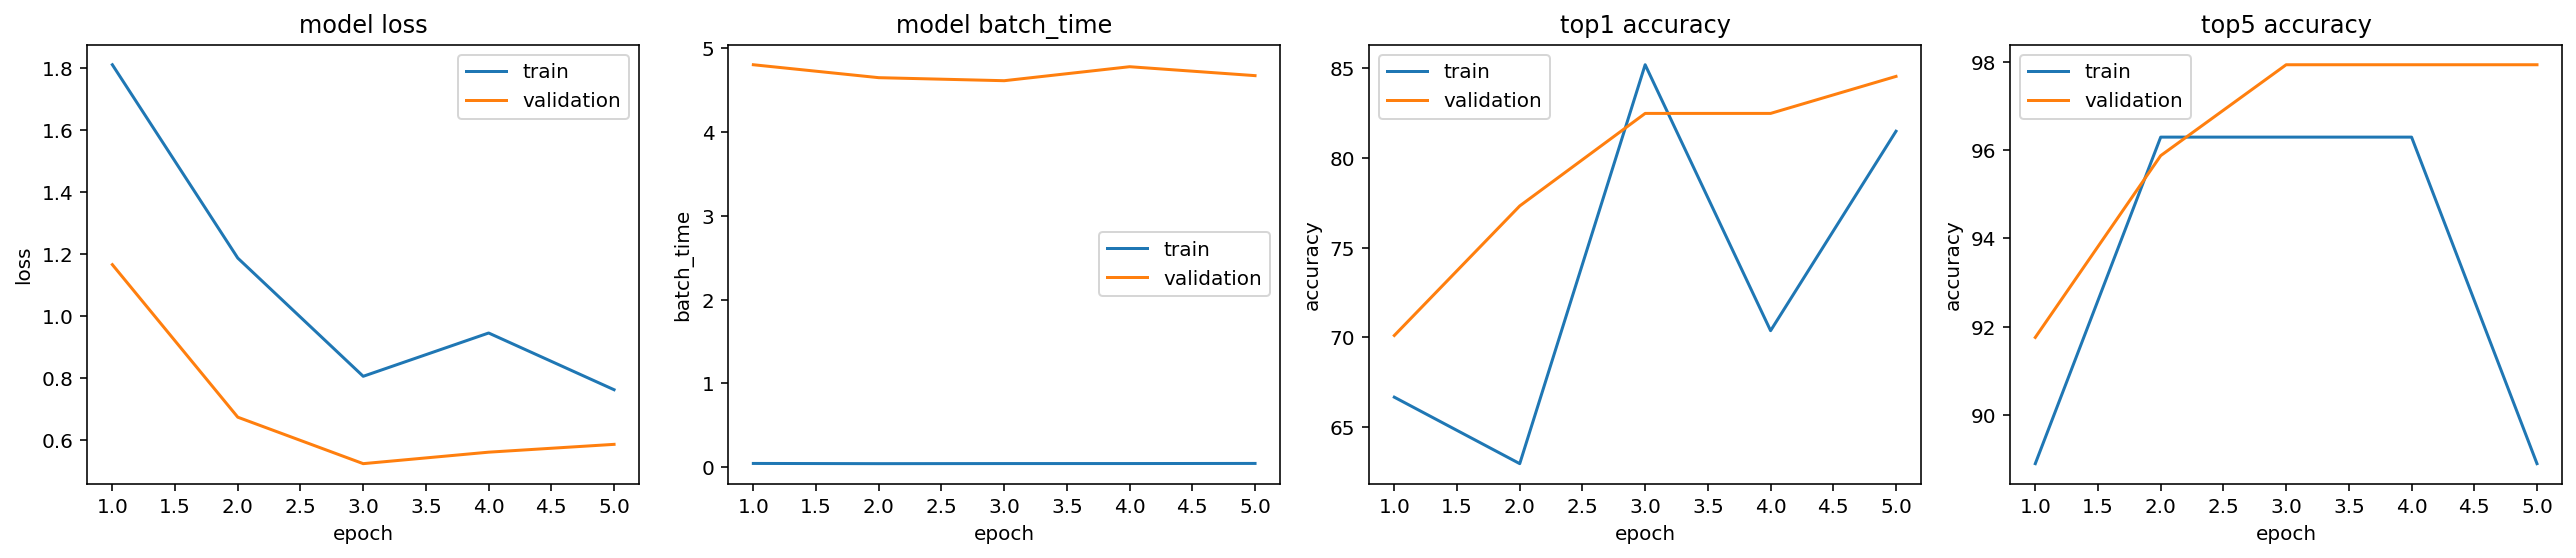

In [62]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=True)
    
    ax = axes[0]
    ax.plot(history['epoch'], history['losses'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_losses'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[1]
    ax.plot(history['epoch'], history['batch_time'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_batch_time'], label='validation')
    ax.set(
        title='model batch_time',
        ylabel='batch_time',
        xlabel='epoch')
    ax.legend()
    
    
    ax = axes[2]
    ax.plot(history['epoch'], history['top1'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top1'], label='validation')
    ax.set(
        title='top1 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    
    ax = axes[3]
    ax.plot(history['epoch'], history['top5'], label='train')
    ax.plot(history['val_avg_epoch'], history['val_avg_top5'], label='validation')
    ax.set(
        title='top5 accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(model_history)

## 16. Debugger Profiling Report 다운로드 받기
Profiling report rule은 html report `profiler-report.html` 생성합니다. 이 Report에는 built-in rules 과 다음 단계에 대한 recommenadation에 대한 요약을 포함하고 있습니다. Report는 S3 bucket에 있으며 아래 cell을 실행하여 노트북으로 다운로드를 받습니다. 자세한 사항은 [SageMaker Debugger Profiling Report](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html) 에서 확인이 가능합니다.

In [63]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output


In [64]:
!aws s3 ls {rule_output_path}/ProfilerReport/profiler-output/

                           PRE profiler-reports/
2021-02-12 02:38:57     411853 profiler-report.html
2021-02-12 02:38:57     276205 profiler-report.ipynb


In [65]:
!aws s3 cp {rule_output_path}/ProfilerReport/profiler-output/ {output_dir}/ProfilerReport/ --recursive

download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to output/ProfilerReport/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to output/ProfilerReport/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to output/ProfilerReport/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to output/ProfilerReport/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-322537213286/apex-dis-training-job-1613096727/rule-output/ProfilerReport/profiler-outpu

In [66]:
from IPython.core.display import display, HTML

display(HTML('<b>ProfilerReport : <a href="{}profiler-report.html">Profiler Report</a></b>'.format(output_dir+"/ProfilerReport/")))


In [67]:
%store hyperparameters model_dir output_dir artifacts_dir

Stored 'hyperparameters' (dict)
Stored 'model_dir' (str)
Stored 'output_dir' (str)
Stored 'artifacts_dir' (str)


<p></p>
<p>Amazon SageMaker에서 모든 학습을 완료하였습니다. </p>